# Prediction

In [21]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd

In [22]:
ann_meta_data = pd.read_csv("keypoint_definitions.csv")
COLORS = ann_meta_data["Hex colour"].values.tolist()

COLORS_RGB_MAP = []
for color in COLORS:
    R, G, B = int(color[:2], 16), int(color[2:4], 16), int(color[4:], 16)
    COLORS_RGB_MAP.append({color: (R,G,B)})

In [23]:
model = YOLO('best.pt')

In [24]:
def draw_landmarks(image, landmarks):

    radius = 5
    # Check if image width is greater than 1000 px.
    # To improve visualization.
    if (image.shape[1] > 1000):
        radius = 8

    for idx, kpt_data in enumerate(landmarks):

        loc_x, loc_y = kpt_data[:2].astype("int").tolist()
        color_id = list(COLORS_RGB_MAP[int(kpt_data[-1])].values())[0]

        cv2.circle(image,
                   (loc_x, loc_y),
                   radius,
                   color=color_id[::-1],
                   thickness=-1,
                   lineType=cv2.LINE_AA)

    return image

In [27]:


def prepare_predictions(
    image_dir_path,
    image_filename,
    model,
    BOX_IOU_THRESH = 0.55,
    BOX_CONF_THRESH=0.30,
    KPT_CONF_THRESH=0.68):

    image_path = os.path.join(image_dir_path, image_filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = model.predict(image_path, conf=BOX_CONF_THRESH, iou=BOX_IOU_THRESH)[0].cpu()

    if not len(results.boxes.xyxy):
        return image

    # Get the predicted boxes, conf scores and keypoints.
    pred_boxes = results.boxes.xyxy.numpy()
    pred_box_conf = results.boxes.conf.numpy()
    pred_kpts_xy = results.keypoints.xy.numpy()
    pred_kpts_conf = results.keypoints.conf.numpy()

    # Draw predicted bounding boxes, conf scores and keypoints on image.
    # Draw predicted bounding boxes, conf scores and keypoints on image.
    for boxes, score, kpts, confs in zip(pred_boxes, pred_box_conf, pred_kpts_xy, pred_kpts_conf):
        kpts_ids = np.where(confs > KPT_CONF_THRESH)[0]
        filter_kpts = kpts[kpts_ids]
        filter_kpts = np.concatenate([filter_kpts, np.expand_dims(kpts_ids, axis=-1)], axis=-1)
        # image = draw_boxes(image, boxes, score=score)
        print('******** filter_kpts: ', filter_kpts)
        image = draw_landmarks(image, filter_kpts)
    cv2.imwrite('/content/drive/MyDrive/APE/proj1/results/result1.jpg', image)
    plt.imshow(image)
    plt.show()



image 1/1 D:\closet\tryon\animal-tryon\input\dog2.jpg: 640x448 1 dog, 560.0ms
Speed: 3.0ms preprocess, 560.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


******** filter_kpts:  [[      432.2      906.23           0]
 [     402.89      794.16           1]
 [     391.72      613.43           2]
 [     202.36      895.44           6]
 [     224.36      785.55           7]
 [     227.94      606.11           8]
 [        424       164.2          14]
 [     304.81      147.58          15]
 [     343.89      322.31          16]
 [     341.35      378.09          17]
 [     450.68        94.5          18]
 [     294.74      73.263          19]]


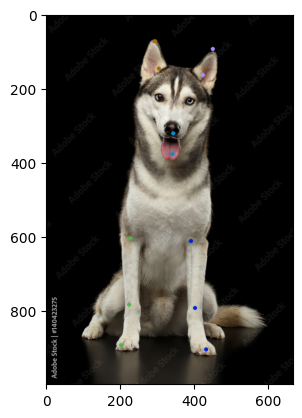

In [26]:
prepare_predictions('', 'input/dog2.jpg', model)